Package Loading

In [ ]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import pandas as pd
import jieba  # Chinese text segmentation library
from nltk.corpus import stopwords
import numpy as np  # Import numpy for handling NaN values

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1. Preprocess the data:
- Fill in the missing column
- Choose the proper features
- Tokenize each sentence in each cell

In [ ]:
df = pd.read_csv('medical_cases.csv')

for column in df:
    # Replace missing values with a placeholder token
    df[column].fillna('未知', inplace=True)

# Tokenization and Cleaning function for Chinese text
def preprocess_chinese_text(text):
    # Check if the value is NaN or non-string, and handle accordingly
    if isinstance(text, str):
        # Tokenize Chinese text using jieba
        words = jieba.lcut(text)

        custom_stop_words = set(stopwords.words('chinese'))
        custom_stop_words.discard('有力')  # Remove '有力' from stop words

        # Remove Chinese stopwords including custom stop words
        cleaned_words = [word for word in words if word not in custom_stop_words]
        # Print the cleaned words after stop words removal

        return cleaned_words
        return words
    else:
        return ''  # Return an empty string or handle as needed for non-string values


2. Try some embedding models

2.1 Word2Vec

In [ ]:
def Word2Vec_Processing(columns_to_tokenize):
  # Preprocess each column
  for column in columns_to_tokenize:
      df[column] = df[column].apply(preprocess_chinese_text)

  # Initialize an empty dictionary to store Word2Vec models for each column
  word2vec_models = {}

  # Loop through the tokenized columns and train Word2Vec models
  for column in columns_to_tokenize:
      word2vec_model = Word2Vec(sentences=df[column], vector_size=200, window=3, min_count=1, workers=4)
      word2vec_models[column] = word2vec_model
  # Initialize a dictionary to store embeddings for each column
  embeddings_for_columns = {}

  # Loop through the columns and generate embeddings
  for column_name in columns_to_tokenize:
      embeddings_for_column = []

      # Generate embeddings for tokens in each column using the corresponding Word2Vec model
      for tokenized_sentence in df[column_name]:
          sentence_embedding = []
          for word in tokenized_sentence:
              if word in word2vec_models[column_name].wv:
                  word_embedding = word2vec_models[column_name].wv[word]
                  sentence_embedding.append(word_embedding)

          # Append the sentence embedding to the list
          embeddings_for_column.append(sentence_embedding)

      # Store embeddings for the column in the dictionary
      embeddings_for_columns[column_name] = embeddings_for_column
  return embeddings_for_columns

3. Handling the vector

- try using average (ver1): not efficient.. skip



- other approaches to get the final embedding vectors

In [ ]:
def VectorGeneration(embeddings):
  # Initialize a dictionary to store aggregated embeddings for each column
  aggregated_embeddings_for_columns = {}

  # Loop through the columns and generate aggregated embeddings
  for column_name in embeddings.keys():

      aggregated_embeddings_for_column = []

      # Calculate aggregated embeddings for tokens in each feature column
      for sentence_embeddings in embeddings[column_name]:
          if not sentence_embeddings:
              # If the feature has no embeddings, append a zero vector
              aggregated_embeddings_for_column.append(np.zeros(word2vec_models[column_name].vector_size))
          else:
              # Calculate different aggregation methods: max, min, sum
              max_embedding = np.max(sentence_embeddings, axis=0)
              min_embedding = np.min(sentence_embeddings, axis=0)
              sum_embedding = np.sum(sentence_embeddings, axis=0)

              # Append the aggregated embeddings to the list
              aggregated_embeddings_for_column.append({
                  'max_embedding': max_embedding,
                  'min_embedding': min_embedding,
                  'sum_embedding': sum_embedding
              })

      # Store aggregated embeddings for the column in the dictionary
      aggregated_embeddings_for_columns[column_name] = aggregated_embeddings_for_column
  return aggregated_embeddings_for_columns

4. Classification Model

4.1. Using Naive Bayes

- For average vector (not good) - skip

- for max, min, sum with Naive Bayes

In [ ]:
herb_columns = ['澤瀉', '黃芩', '桂枝', '炙甘草', '白芍']
def get_features (herb):
    for herb in herb_columns:
        if herb == '澤瀉': #It is antibacterial, anticholesterolemic, diuretic and
            columns = ['大便','渴','頭身','月經','其他','脈診',	'望診',
                            '舌診','眼診',	'特殊診斷', '耳診','診斷']
        elif herb == '黃芩': #- To treat hepatitis, arthritis, cancer: liver, cancer and bones related
            columns =  ['睡眠', '大便','小便','胃口','渴', '手足',
                            '頭身','汗','月經','其他','脈診',	'望診',
                            '舌診','眼診',	'特殊診斷', '耳診','診斷']
        elif herb == '桂枝': # - treat gastrointestinal dysfunction, cancer, arthritis, osteoporosis, sleep deficiency, Alzheimer's disease and obesity.
            columns =  ['來診原因','睡眠', '大便','小便','胃口','渴', '手足',
                            '頭身','汗','其他','脈診',	'望診',
                            '舌診','特殊診斷', '耳診','診斷', '解說']
        elif herb == '白芍': # - white peony root, treat a wide range of ailments, including fever, inflammation, and pain
            columns = ['來診原因','睡眠', '大便','小便','胃口','渴', '手足',
                            '頭身','汗','月經','其他','脈診',	'望診',
                            '舌診','特殊診斷', '眼診','耳診','診斷', '解說', '性別']
        elif herb == '炙甘草': # - licorice root, can help to relieve fatigue, general weakness, poor appetite and loose bowels
            columns = ['來診原因','睡眠', '大便','小便','胃口','渴', '手足',
                            '頭身','汗','月經','其他','脈診',	'望診',
                            '舌診','特殊診斷', '眼診','耳診','診斷', '解說']
            # ['大便', '胃口', '渴', '頭身', '其他', '特殊診斷', '診斷', '來診原因']
        return columns
total_columns = ['來診原因','睡眠', '大便','小便','胃口','渴', '手足',
                            '頭身','汗','月經','其他','脈診',	'望診',
                            '舌診','特殊診斷', '眼診','耳診','診斷', '解說']
embeddings = Word2Vec_Processing(total_columns)
aggregated_embeddings_for_columns = VectorGeneration(embeddings)


Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 2.348 seconds.
DEBUG:jieba:Loading model cost 2.348 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


In [ ]:
print("Metrics using word embedding:")
for herb in herb_columns:
    features = get_features(herb)

    scaler = MinMaxScaler()
    scaled_vectors_columns = {}  # Dictionary to store scaled features
    for column in aggregated_embeddings_for_columns:
        if column in features:
            # Extract the aggregated embeddings for the column
            embeddings = aggregated_embeddings_for_columns[column]


            # Convert the list of dicts to an array
            if(herb == '澤瀉'):
              X = np.array([embeddings[i]['min_embedding'] for i in range(len(embeddings))])  # Choose 'max_embedding', 'min_embedding', or 'sum_embedding'
            elif(herb == '桂枝' or herb == '黃芩' or herb == '炙甘草'):
              X = np.array([embeddings[i]['sum_embedding'] for i in range(len(embeddings))])  # Choose 'max_embedding', 'min_embedding', or 'sum_embedding'
            else:
              X = np.array([embeddings[i]['max_embedding'] for i in range(len(embeddings))])  # Choose 'max_embedding', 'min_embedding', or 'sum_embedding'

            # Scale the embeddings for the column
            scaled_vectors_columns[column] = scaler.fit_transform(X)  # Scale each feature separately

    # Combine the scaled features into a single array
    combined_features = np.concatenate(list(scaled_vectors_columns.values()), axis=1)
    y_label = df[herb]
    nb_classifier = MultinomialNB()
    rf_classifier = RandomForestClassifier(n_estimators=20, random_state=222, criterion='entropy')
    X_train, X_test, y_train, y_test = train_test_split(combined_features, y_label, test_size=0.2, random_state=18)


    # Fit the classifier on the scaled training data
    if(herb == '澤瀉' or herb == '桂枝' or herb == '白芍' or herb == '炙甘草'):
      rf_classifier.fit(X_train, y_train)
      predictions_rf = rf_classifier.predict(X_test)
      accuracy_rf = accuracy_score(y_test, predictions_rf)
      f1_rf = f1_score(y_test, predictions_rf, average='weighted')
      precision_rf = precision_score(y_test, predictions_rf, average='weighted')
      recall_rf = recall_score(y_test, predictions_rf, average='weighted')
      print(f"RF: Accuracy of {herb}: {accuracy_rf:.4f}")
      print(f"RF: F1-score of {herb}: {f1_rf:.4f}")
      print(f"RF: Precision of {herb}: {precision_rf:.4f}")
      print(f"RF: Recall of {herb}: {recall_rf:.4f}\n")
    else:
      nb_classifier.fit(X_train, y_train)
      predictions = nb_classifier.predict(X_test)
      accuracy = accuracy_score(y_test, predictions)
      f1 = f1_score(y_test, predictions, average='weighted')
      precision = precision_score(y_test, predictions, average='weighted')
      recall = recall_score(y_test, predictions, average='weighted')
      print(f"NB: Accuracy of {herb}: {accuracy:.4f}")
      print(f"NB: F1-score of {herb}: {f1:.4f}")
      print(f"NB: Precision of {herb}: {precision:.4f}")
      print(f"NB: Recall of {herb}: {recall:.4f}\n")

Metrics using word embedding:
RF: Accuracy of 澤瀉: 0.7188
RF: F1-score of 澤瀉: 0.6966
RF: Precision of 澤瀉: 0.7240
RF: Recall of 澤瀉: 0.7188

NB: Accuracy of 黃芩: 0.5938
NB: F1-score of 黃芩: 0.5622
NB: Precision of 黃芩: 0.5940
NB: Recall of 黃芩: 0.5938

RF: Accuracy of 桂枝: 0.6438
RF: F1-score of 桂枝: 0.6430
RF: Precision of 桂枝: 0.6424
RF: Recall of 桂枝: 0.6438

RF: Accuracy of 炙甘草: 0.5875
RF: F1-score of 炙甘草: 0.5730
RF: Precision of 炙甘草: 0.5772
RF: Recall of 炙甘草: 0.5875

RF: Accuracy of 白芍: 0.6188
RF: F1-score of 白芍: 0.6079
RF: Precision of 白芍: 0.6472
RF: Recall of 白芍: 0.6188



5. Compare to the version using binary features only

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


# Combine the scaled features into a single array

binary_column = ['倦怠', '咳嗽', '無力', '血壓', '化療', '診因月經', '背痛', '胃酸', '更年期', '心悸',
                 '過敏', '中風', '糖尿病', '失眠', '耳鳴', '抽筋', '肺積水', '甲狀腺', '卵巢', '焦慮',
                 '痔瘡', '腹痛', '睡眠好', '睡眠不好', '睡時身熱', '睡時身冷', '睡時身溫', '時醒', '時好時壞',
                 '多夢', '雙足冷', '夜尿', '診因汗', '安眠藥', '大便每日行', '大便每日二行', '大便每日三行', '大便正常',
                 '便祕', '排氣', '無排氣', '下利', '大便軟', '大便隔日', '大便不規則', '未盡感', '大便色深', '大便色黃',
                 '小便淡白', '小便淡黃', '小便中黃', '小便深黃', '小便正常', '泡沫', '頻尿', '量少', '尿意', '滴漏', '力量',
                 '胃口不好', '胃口尚好', '胃口正常', '胃口平平', '胃口下降', '胃口過好', '噁心', '無噁心', '會餓', '胃口時好時壞',
                 '口渴尚好', '口渴無', '口渴重', '喜冷', '喜熱', '喜溫', '不渴', '口乾', '雙足熱', '雙足溫', '手熱', '手溫', '手冷',
                 '冰冷', '稍冷', '手足皆冷', '額溫', '額熱', '手足正常', '手腳水腫', '手足時麻', '手足不麻', '手足出汗', '易出汗',
                 '不易出汗', '盜汗', '無盜汗']
combined_binary = df.loc[:,binary_column]

# X_vectors contain the transformed vectors for each sentence
# y contains the corresponding labels for classification

herb_columns = ['澤瀉', '黃芩', '桂枝', '炙甘草', '白芍']
y_labels = df[herb_columns]
# Split the combined features into train and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_binary, y_labels, test_size=0.2, random_state=18)

rf_classifier = RandomForestClassifier(n_estimators=20, random_state=222, criterion='entropy')
# Initialize MultiOutputClassifier with RandomForestClassifier
multi_output_classifier = MultiOutputClassifier(rf_classifier, n_jobs=-1)

# Fit the multi-output classifier on the training data
multi_output_classifier.fit(X_train, y_train)

# Predict on test data
predictions = multi_output_classifier.predict(X_test)

# Calculate accuracy for each column
for i, column in enumerate(herb_columns):
    accuracy = accuracy_score(y_test[column], predictions[:, i])
    f1 = f1_score(y_test[column], predictions[:, i], average='weighted')
    precision = precision_score(y_test[column], predictions[:, i], average='weighted')
    recall = recall_score(y_test[column], predictions[:, i], average='weighted')

    print(f"Metrics for {herb_columns[i]} using binary features:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-score: {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")

Metrics for 澤瀉:
  Accuracy: 0.5500
  F1-score: 0.5081
  Precision: 0.5017
  Recall: 0.5500
Metrics for 黃芩:
  Accuracy: 0.5938
  F1-score: 0.5827
  Precision: 0.5888
  Recall: 0.5938
Metrics for 桂枝:
  Accuracy: 0.5813
  F1-score: 0.5879
  Precision: 0.5998
  Recall: 0.5813
Metrics for 炙甘草:
  Accuracy: 0.5750
  F1-score: 0.5695
  Precision: 0.5684
  Recall: 0.5750
Metrics for 白芍:
  Accuracy: 0.5687
  F1-score: 0.5615
  Precision: 0.5832
  Recall: 0.5687


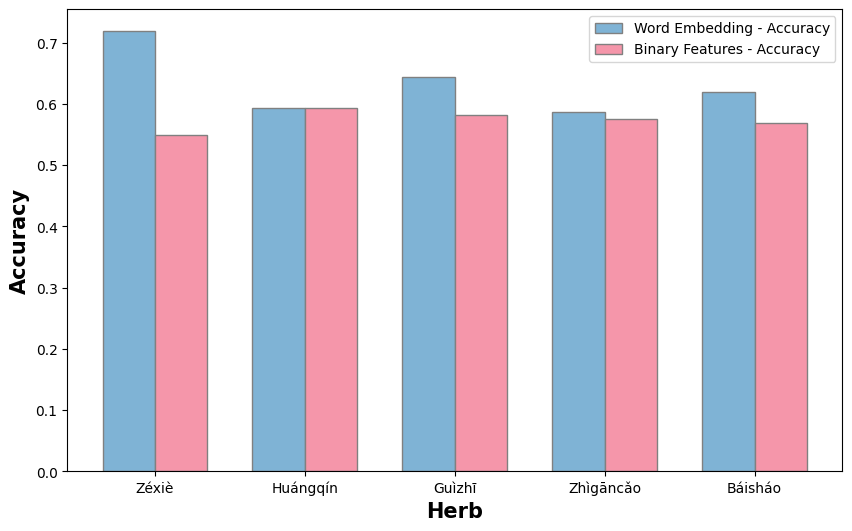

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Herb names
herb_columns = ['Zéxiè', 'Huángqín', 'Guìzhī', 'Zhìgāncǎo', 'Báisháo']

# Results for word embedding
accuracy_word_embedding = [0.7188, 0.5938, 0.6438, 0.5875, 0.6188]
f1_word_embedding = [0.6966, 0.5622, 0.6430, 0.5730, 0.6079]
precision_word_embedding = [0.7240, 0.5940, 0.6424, 0.5772, 0.6472]
recall_word_embedding = [0.7188, 0.5938, 0.6438, 0.5875, 0.6188]

# Results for binary features
accuracy_binary = [0.5500, 0.5938, 0.5813, 0.5750, 0.5687]
f1_binary = [0.5081, 0.5827, 0.5879, 0.5695, 0.5615]
precision_binary = [0.5017, 0.5888, 0.5998, 0.5684, 0.5832]
recall_binary = [0.5500, 0.5938, 0.5813, 0.5750, 0.5687]

# Set up figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Set width of the bars
bar_width = 0.35

# Set position of bar on X axis
r1 = np.arange(len(herb_columns))
r2 = [x + bar_width for x in r1]

# Create bars
plt.bar(r1, accuracy_word_embedding, color='#7FB3D5', width=bar_width, edgecolor='grey', label='Word Embedding - Accuracy')
plt.bar(r2, accuracy_binary, color='#F596AA', width=bar_width, edgecolor='grey', label='Binary Features - Accuracy')

# Add labels
plt.xlabel('Herb', fontweight='bold', fontsize=15)
plt.ylabel('Accuracy', fontweight='bold', fontsize=15)
plt.xticks([r + bar_width/2 for r in range(len(herb_columns))], herb_columns)

# Add legend
plt.legend()

# Show plot
plt.show()


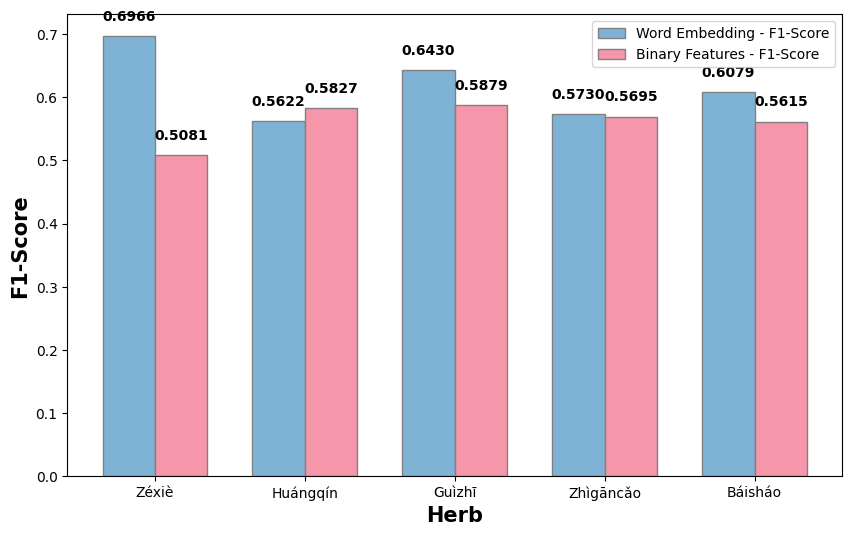

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Herb names
herb_columns = ['Zéxiè', 'Huángqín', 'Guìzhī', 'Zhìgāncǎo', 'Báisháo']

# Results for word embedding
f1_word_embedding = [0.6966, 0.5622, 0.6430, 0.5730, 0.6079]
f1_binary = [0.5081, 0.5827, 0.5879, 0.5695, 0.5615]

# Set up figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Set width of the bars
bar_width = 0.35

# Set position of bar on X axis
r1 = np.arange(len(herb_columns))
r2 = [x + bar_width for x in r1]

# Create bars
plt.bar(r1, f1_word_embedding, color='#7FB3D5', width=bar_width, edgecolor='grey', label='Word Embedding - F1-Score')
plt.bar(r2, f1_binary, color='#F596AA', width=bar_width, edgecolor='grey', label='Binary Features - F1-Score')

# Add labels
plt.xlabel('Herb', fontweight='bold', fontsize=15)
plt.ylabel('F1-Score', fontweight='bold', fontsize=15)
plt.xticks([r + bar_width/2 for r in range(len(herb_columns))], herb_columns)

# Add legend
plt.legend()

# Add values on top of each column
for i, value in enumerate(f1_word_embedding):
    plt.text(i, value + 0.02, f'{value:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

for i, value in enumerate(f1_binary):
    plt.text(i + bar_width, value + 0.02, f'{value:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Show plot
plt.show()
